This notebook computes the lag-energy spectrum from the saved cross spectrum.

In [1]:
import numpy as np
from astropy.table import Table, Column
from astropy.io import fits
from scipy.stats import binned_statistic
import os
import subprocess
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter, NullFormatter
import matplotlib.colors as colors
%matplotlib inline
from xcor_tools import find_nearest, pairwise

In [2]:
homedir = os.path.expanduser("~")
maxi_dir = homedir+"/Dropbox/Research/MAXIJ1535_B-QPO"
cs_file = maxi_dir+"/out/MAXIJ1535_64sec_256dt_cs.fits"
assert os.path.isfile(cs_file)

cs_tab = Table.read(cs_file, format='fits')
print(cs_tab.info)
print(cs_tab.meta)

<Table length=16384>
   name     dtype    shape    unit                 description               
--------- ---------- ----- --------- ----------------------------------------
FREQUENCY    float32              Hz                        Fourier frequency
  PSD_ALL    float64       abs rms^2 PSD of all MPUs, 3-10 keV, w Poiss noise
  PSD_REF    float64       abs rms^2                   Ref PSD, w Poiss noise
   PSD_CI    float64 (62,) abs rms^2                    CI PSD, w Poiss noise
    CROSS complex128 (62,)                             CS, unnorm, unfiltered

OrderedDict([('OBJECT', 'MAXI_J1535-571'), ('INST', 'NICER'), ('TODAY', '2018-06-01 12:42:27.430595'), ('TYPE', 'Segments selected on rms and hr'), ('INFILE', '/Users/abbie/Dropbox/Research/MAXIJ1535_B-QPO/bqpo_evtlists.txt'), ('EXPOSURE', 34112), ('N_BINS', 16384), ('DT', 0.00390625), ('DF', 0.015625), ('N_CHANS', 62), ('CHBINFIL', '/Users/abbie/Dropbox/Research/MAXIJ1535_B-QPO/chbinfile.txt'), ('N_SEG', 533), ('N_SECOND', 64),

In [3]:
print(cs_tab['FREQUENCY'][1])

0.015625


In [4]:
class Energy_lags(object):
    """
    Compute the lag-energy spectrum. Assumes incoming power spectra are 
    abs rms^2 normalized and NOT Poisson-noise-subtracted.
    """
    def __init__(self, in_tab, low_freq_bound=3., 
                 high_freq_bound=9., debug=False):
        assert isinstance(low_freq_bound, float), "`low_freq_bound` should be a float."
        assert isinstance(high_freq_bound, float), "`high_freq_bound` should be a float."
        assert isinstance(debug, bool), "`debug` should be a boolean."
        assert isinstance(in_tab, Table), "`in_tab` should be an astropy Table object."
        assert low_freq_bound < high_freq_bound, "`low_freq_bound` must be less than `high_freq_bound`."
        self.debug = debug

        if self.debug:
            print("L f bound: " + str(low_freq_bound))
            print("H f bound: " + str(high_freq_bound))
            
        assert len(np.shape(in_tab['PSD_REF'])) == 1
        assert len(np.shape(in_tab['PSD_CI'])) == 2
        assert len(np.shape(in_tab['CROSS'])) == 2
        self.n_bins = in_tab.meta['N_BINS']
        self.n_chans = in_tab.meta['N_CHANS']
        self.n_seg = in_tab.meta['N_SEG']
        self.dt = in_tab.meta['DT']
        self.rate_ref = in_tab.meta['RATE_REF']
        self.rate_ci = np.asarray(in_tab.meta['RATE_CI'][1:-1].split(","), 
                                  dtype='float')

        freq = np.abs(in_tab['FREQUENCY'][0:int(self.n_bins/2+1)])
        ## Using the unfiltered (but still shifted) cs & psd
        cs = in_tab['CROSS'][0:int(self.n_bins/2+1), :]
        psd_ci = in_tab['PSD_CI'][0:int(self.n_bins/2+1), :]
        psd_ref = in_tab['PSD_REF'][0:int(self.n_bins/2+1)]
        
        a, f_mask_low = find_nearest(freq, low_freq_bound)
        a, f_mask_high = find_nearest(freq, high_freq_bound)
        if self.debug:
            print("Low freq: " + str(freq[f_mask_low]))
            print("High freq: " + str(freq[f_mask_high]))

        f_span = f_mask_high - f_mask_low + 1  ## including both ends
        mean_f = np.mean(freq[f_mask_low:f_mask_high+1])
    
        temp_tab = Table()
        tt_f = np.repeat(mean_f, self.n_chans)
        temp_tab['FREQUENCY'] = Column(tt_f, dtype=np.float32, unit='Hz')
        tt_cs = np.mean(cs[f_mask_low:f_mask_high+1,], axis=0)
        temp_tab['CROSS'] = Column(tt_cs, dtype=np.complex128, unit='---')
        tt_pc = np.mean(psd_ci[f_mask_low:f_mask_high+1,], axis=0)
        temp_tab['POWER_CI'] = Column(tt_pc, dtype=np.float64, unit='---')
        tt_pr = np.repeat(np.mean(psd_ref[f_mask_low:f_mask_high+1]), self.n_chans)
        temp_tab['POWER_REF'] = Column(tt_pr, dtype=np.float64, unit='---') 
        if self.debug:
            print(temp_tab.info)
            
        energy_tab = Table()
        energy_tab['CHANNEL'] = Column(np.arange(int(self.n_chans)),
                                        description='Energy channel of interest',
                                        dtype=np.int, unit='chan')
        energy_tab['PHASE_LAG'] = Column(-np.arctan2(temp_tab['CROSS'].imag,
                                                      temp_tab['CROSS'].real),
                                          unit='rad', description='Phase lag',
                                          dtype=np.float64)
        energy_tab['PHASE_ERR'] = Column(self._phase_err(temp_tab, f_span),
                                          unit='rad', dtype=np.float64,
                                          description='Error on phase lag')
        energy_tab['TIME_LAG'] = Column(self._phase_to_tlags(energy_tab['PHASE_LAG'], 
                                                              temp_tab['FREQUENCY']),
                                         unit='s', dtype=np.float64, description='Time lag')
        energy_tab['TIME_ERR'] = Column(self._phase_to_tlags(energy_tab['PHASE_ERR'],
                                                              temp_tab['FREQUENCY']),
                                         unit='s', dtype=np.float64, description='Error on time lag')

        if self.debug:
            print(energy_tab.info)
            
        self.energy_tab = energy_tab

    def _phase_err(self, tab, n_range=1):
        """
        Compute the error on the complex phase (in radians) via the coherence.
        Power is assumed to be abs rms^2 units and NOT Poisson-noise-subtracted.

        Parameters
        ----------
        tab : Astropy table

        n_range : int or np.array of ints
            Number of frequency bins averaged over per new frequency bin for
            lags. For energy lags, this is the number of frequency bins averaged
            over. For frequency lags not re-binned in frequency, this is 1.
            Same as K in equations in Section 2 of Uttley et al. 2014.

        Returns
        -------
        phase_err : np.array of floats
            1-D array of the error on the phase of the lag.
        """
#         if self.debug:
#             print("Phase err")
        coherence = self._comp_coherence(tab, n_range)
        coherence[coherence == 0] = 1e-14
        phase_err = np.sqrt(np.abs(1 - coherence) / \
                            (2 * coherence * n_range * self.n_seg))
        return phase_err

    def _phase_to_tlags(self, phase, f):
        """
        Convert a complex-plane cross-spectrum phase (in radians) to a time lag
        (in seconds).
        """
#         if self.debug:
#             print("Phase to time lags")
        f[f == 0] = 1e-14
        tlags = phase / (2.0 * np.pi * f)
        return tlags
    
    def _comp_coherence(self, tab, n_range):
        """
        Compute the raw coherence of the cross spectrum. Coherence equation from
        Uttley et al 2014 eqn 11, bias term equation from footnote 4 on same
        page.
        Assuming that the power spectra have abs rms^2 normalization and do NOT 
        have Poisson noise subtracted.

        Parameters
        ----------
        tab : astropy Table

        Returns
        -------
        coherence : np.array of floats
            The raw coherence of the cross spectrum. (Uttley et al 2014, eqn 11)
            Size = n_chans.
        """
#         if self.debug:
#             print("Compute coherence")
#             print("nrange: "+str(n_range))
#         cs_bias = self._bias_term(tab, n_range)
        ## Setting bias to 0 since i'm using filtered cs and psds for the computations.
        cs_bias = 0  ## Reasonable assumption, most of the time.
        if self.debug:
            print("WARNING: Assuming bias term for coherence is 0.")
        temp_2 = (np.abs(tab['CROSS'])* (2*self.dt/self.n_bins)) ** 2 - cs_bias
        powers = tab['POWER_CI'] * tab['POWER_REF']
        powers[powers == 0] = 1e-14
        coherence = temp_2 / powers
        return np.real(coherence)

    def _bias_term(self, tab, n_range):
        """
        Compute the bias term to be subtracted off the cross spectrum to compute
        the covariance spectrum. Equation in Equation in footnote 4 (section 2.1.3,
        page 12) of Uttley et al. 2014.

        Assumes power spectra are abs rms^2 normalized but NOT Poisson-noise-
        subtracted.

        Parameters
        ----------
        tab : astropy.table.Table

        n_range : int
            Number of frequency bins averaged over per new frequency bin for lags.
            For energy lags, this is the number of frequency bins averaged over. For
            frequency lags not re-binned in frequency, this is 1. For frequency lags
            that have been re-binned, this is a 1-D array with ints of the number of
            old bins in each new bin. Same as K in equations in Section 2 of
            Uttley et al. 2014. Default=1

        Returns
        -------
        n_squared : float
            The bias term to be subtracted off the cross spectrum for computing the
            covariance spectrum. Equation in footnote 4 (section 2.1.3, page 12) of
            Uttley et al. 2014.

        """
        ## Compute the Poisson noise level in absolute rms units
        Pnoise_ref = self.rate_ref * 2.0
        Pnoise_ci = self.rate_ci * 2.0

#         ## Normalizing power spectra to absolute rms normalization
#         ## Not subtracting the noise (yet)!
#         abs_ci = tab['POWER_CI'] * (2.0 * self.dt / n_range)
#         abs_ref = tab['POWER_REF'] * (2.0 * self.dt / n_range)

        temp_a = (tab['POWER_REF'] - Pnoise_ref) * Pnoise_ci
        temp_b = (tab['POWER_CI'] - Pnoise_ci) * Pnoise_ref
        temp_c = Pnoise_ref * Pnoise_ci

        n_squared = np.asarray((temp_a + temp_b + temp_c) / (n_range * self.n_seg))
        return n_squared

In [5]:
rsp_matrix_file = maxi_dir+"/nicer_v1.02rbn.rsp"
assert os.path.isfile(rsp_matrix_file)
rsp = Table.read(rsp_matrix_file, format='fits', hdu='EBOUNDS')
energy_list = np.asarray([np.mean([x, y]) for x,y in zip(rsp['E_MIN'], rsp['E_MAX'])])
e_chans = rsp['CHANNEL']
energy_step = energy_list - rsp['E_MIN']

In [39]:
# lf = 0.015625
# hf = 1.0
# lag_string="bbn"
# lf = 4.27875
# hf = 7.13125
# lag_string = "qpo"
lf = 9.483765
hf = 12.892635
lag_string = "harmonic"

# lag_string = str(lf).replace('.','o')+"-"+str(hf).replace('.','o')
lags = Energy_lags(cs_tab, low_freq_bound=lf, high_freq_bound=hf, debug=False)
print(lags.energy_tab.info)
lags.energy_tab.write(maxi_dir+"/out/lags_%s.fits" % (lag_string), format='fits', overwrite=True)

<Table length=62>
   name    dtype  unit        description        
--------- ------- ---- --------------------------
  CHANNEL   int64 chan Energy channel of interest
PHASE_LAG float64  rad                  Phase lag
PHASE_ERR float64  rad         Error on phase lag
 TIME_LAG float64    s                   Time lag
 TIME_ERR float64    s          Error on time lag



/anaconda3/envs/maxij1535/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


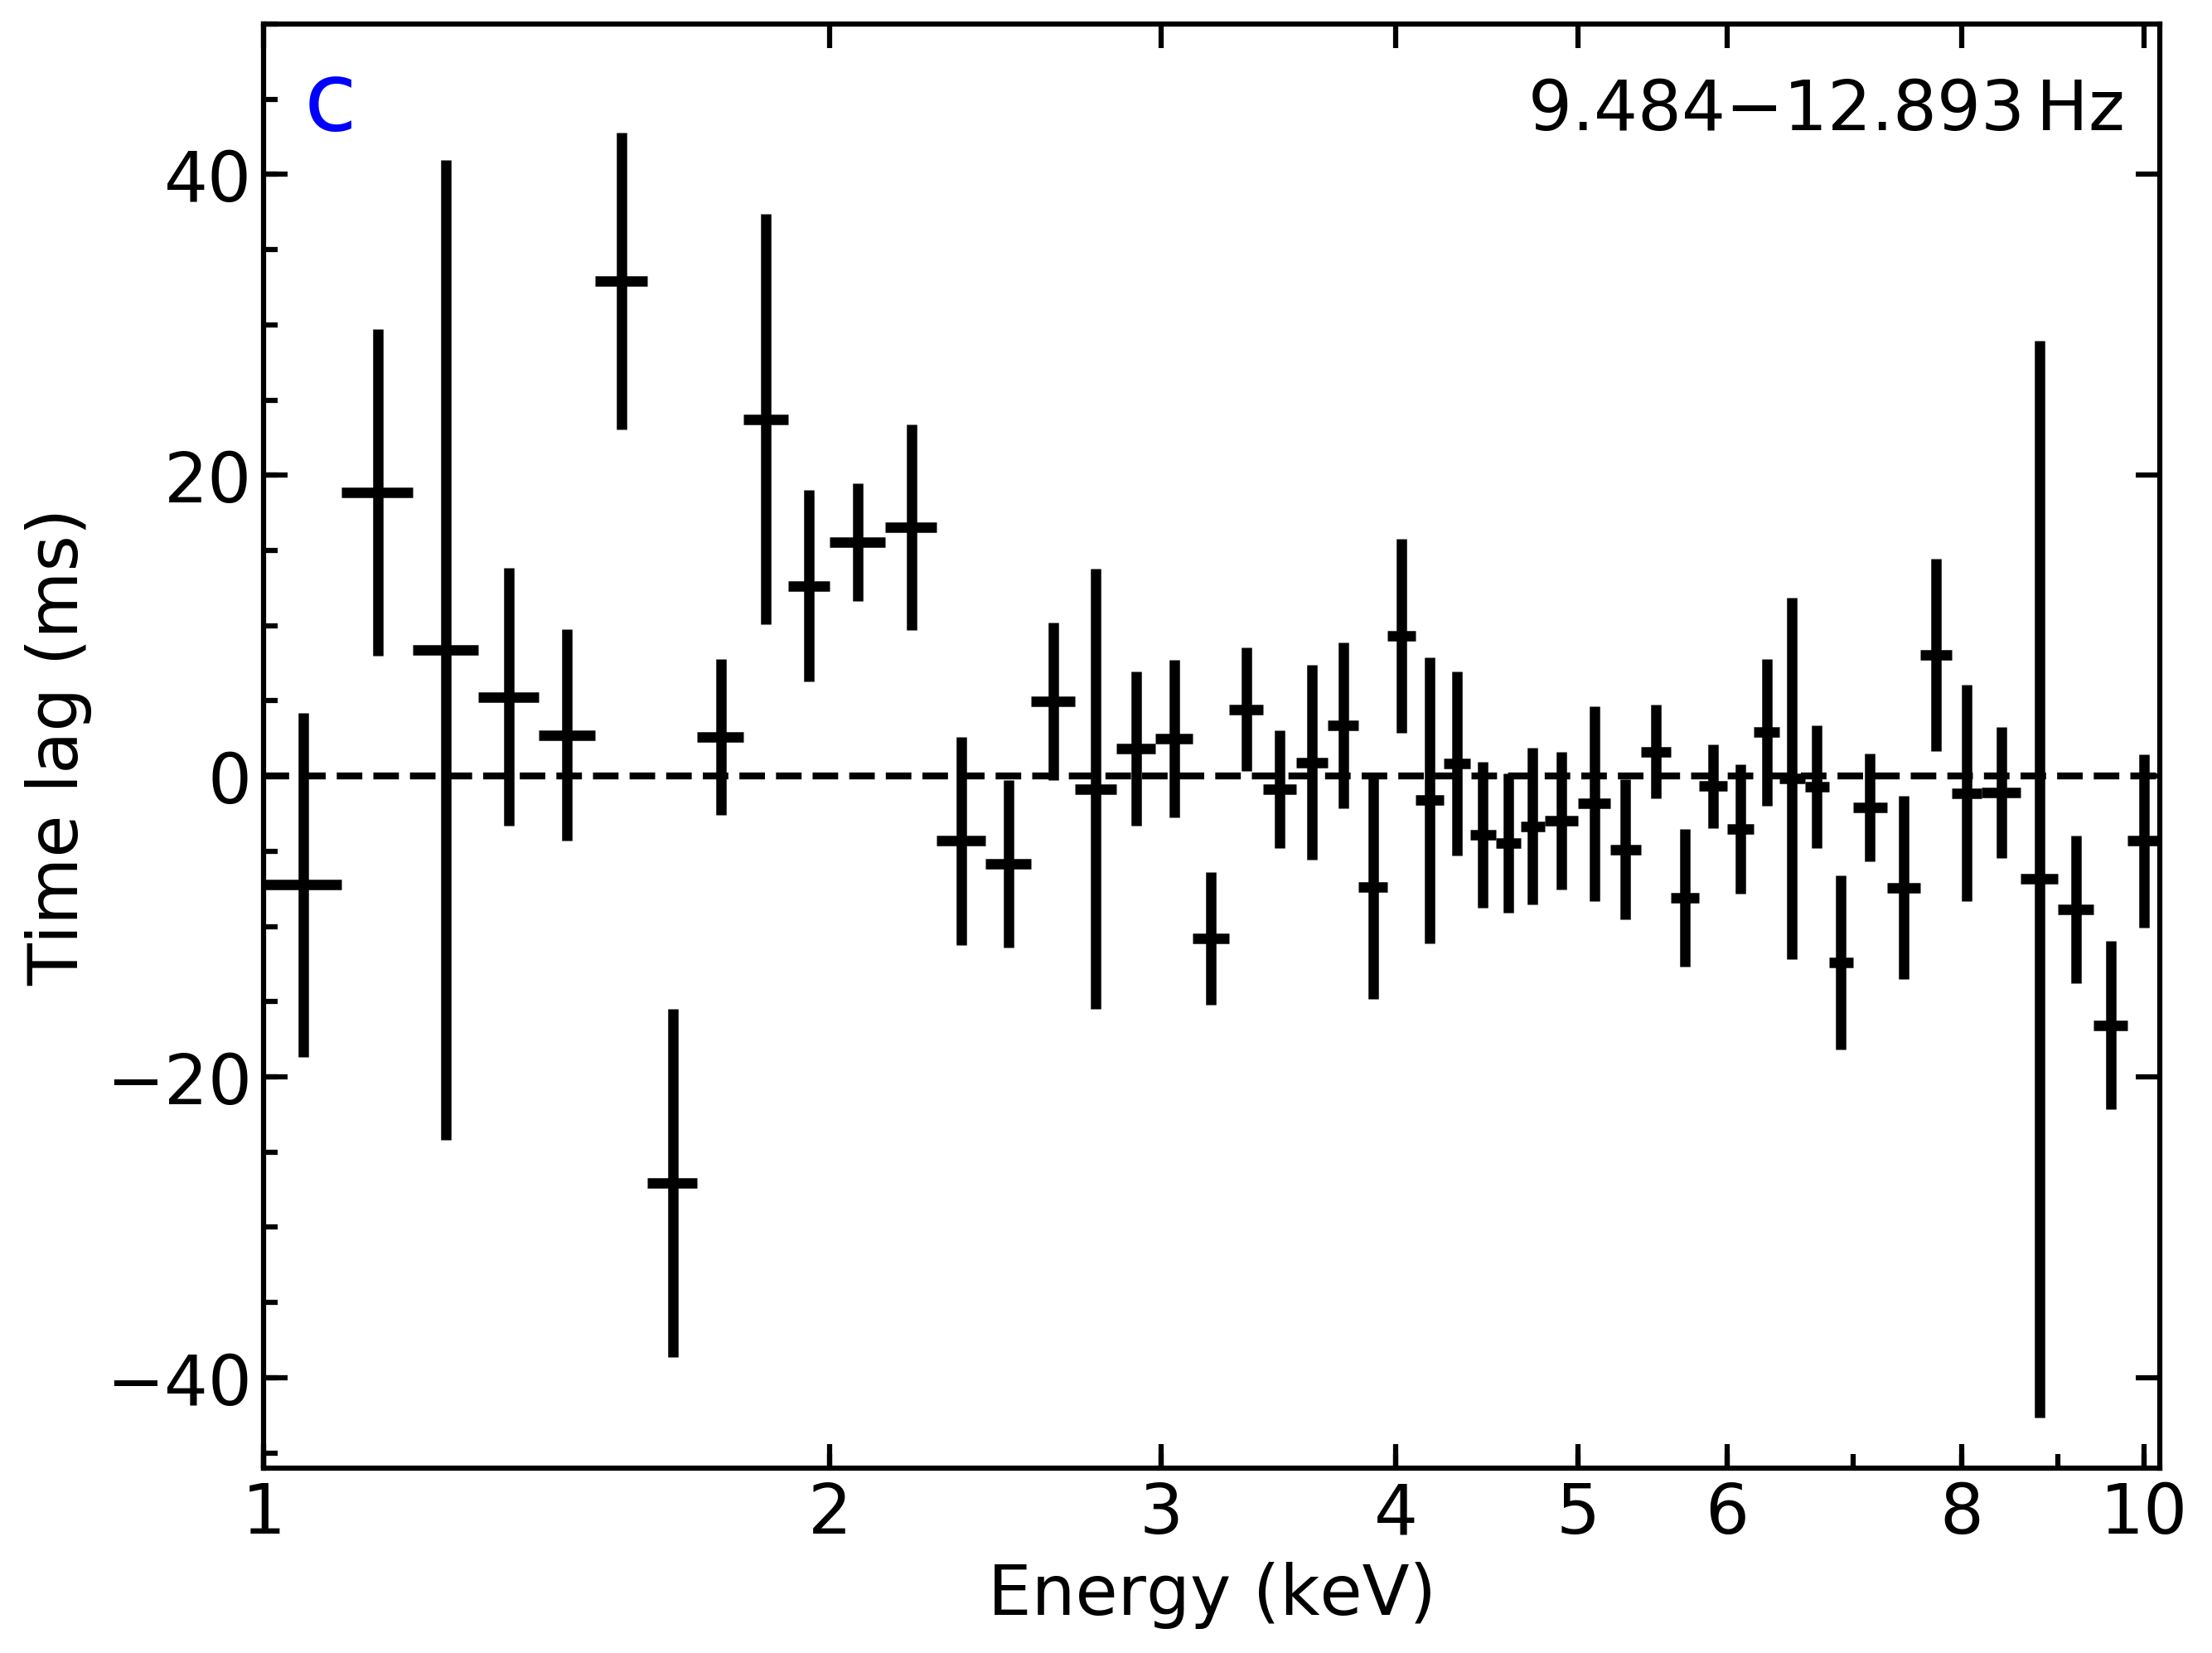

In [40]:
## Putting the time lags in units of milliseconds
tlag = lags.energy_tab['TIME_LAG'] / 1e-3
tlag_err = lags.energy_tab['TIME_ERR'] / 1e-3

font_prop = font_manager.FontProperties(size=20)
fig, ax = plt.subplots(1, 1, figsize=(9,6.75), dpi=300, tight_layout=True)
ax.hlines(0.0, 1, 10.2, linestyle='dashed', lw=2, color='black')
ax.errorbar(energy_list[:-2], tlag[:-2], xerr=energy_step[:-2], 
            yerr=tlag_err[:-2], lw=3, drawstyle='steps-mid', ls='none', 
            ms=10, mew=2, mec="black", mfc='black',
            color="black", ecolor="black", elinewidth=3, capsize=0)

# BBN:
# ax.set_ylim(-150, 400)
# ax.text(1.05, 360, 'a', fontsize=28, color='blue')
# ax.text(4.95, 360, r'%.6f$-$%.0f$\,$Hz' % (lf,hf), fontsize=20)
# yLocator = MultipleLocator(10)  ## loc of minor ticks on y-axis

# QPO:
# ax.set_ylim(-28, 80)
# ax.text(1.08, 72, 'b', fontsize=28, color='blue')
# ax.text(5, 72, r'%.3f$-$%.3f$\,$Hz' % (lf,hf), fontsize=20)
# yLocator = MultipleLocator(5)  ## loc of minor ticks on y-axis

# Harmonic
ax.set_ylim(-46, 50)
ax.text(1.05, 43, 'c', fontsize=28, color='blue')
ax.text(4.7, 43, r'%.3f$-$%.3f$\,$Hz' % (lf,hf), fontsize=20)
yLocator = MultipleLocator(5)  ## loc of minor ticks on y-axis

ax.yaxis.set_minor_locator(yLocator)
ax.set_ylabel(r'Time lag (ms)', fontproperties=font_prop)
ax.set_xlabel('Energy (keV)', fontproperties=font_prop)
ax.set_xlim(1, 10.2)
ax.set_xscale('log')
x_maj_loc = [1,2,3,4,5,6,8,10]
ax.set_xticks(x_maj_loc)
xLocator = MultipleLocator(1)  ## loc of minor ticks on x-axis
ax.xaxis.set_minor_locator(xLocator)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.tick_params(axis='x', labelsize=20, bottom=True, top=True,
                labelbottom=True, labeltop=False, direction="in")
ax.tick_params(axis='y', labelsize=20, left=True, right=True,
                labelleft=True, labelright=False, direction="in")
ax.tick_params(which='major', width=1.5, length=7, direction="in")
ax.tick_params(which='minor', width=1.5, length=4, direction="in")
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plotfile = "lags_%s.eps" % (lag_string)
plt.savefig(maxi_dir+"/out/"+plotfile, dpi=300)
plt.show()

In [16]:
print(plotfile)

lags_bbn.eps


In [ ]:
# plag = lags.energy_tab['PHASE_LAG'] / (2*np.pi)
# plag_err = lags.energy_tab['PHASE_ERR'] / (2*np.pi)

# ax.errorbar(energy_list, plag, xerr=energy_step, yerr=plag_err, 
#             lw=3, drawstyle='steps-mid', ls='none', ms=10,
#             mew=2, marker='o', mec="black", mfc='black',
#             color="black", ecolor="black", elinewidth=3, capsize=0)
# ax.set_ylim(-0.1, 0.3)
# ax.set_ylabel(r'Phase lag (cycles)', fontproperties=font_prop)